# LSTM - enhanced deep Koopman 

## NeuroMANCER and Dependencies

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import time as tim

from neuromancer.psl import plot
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from models import TwoTank

torch.manual_seed(0)

## Generate trajectories from ODE system 

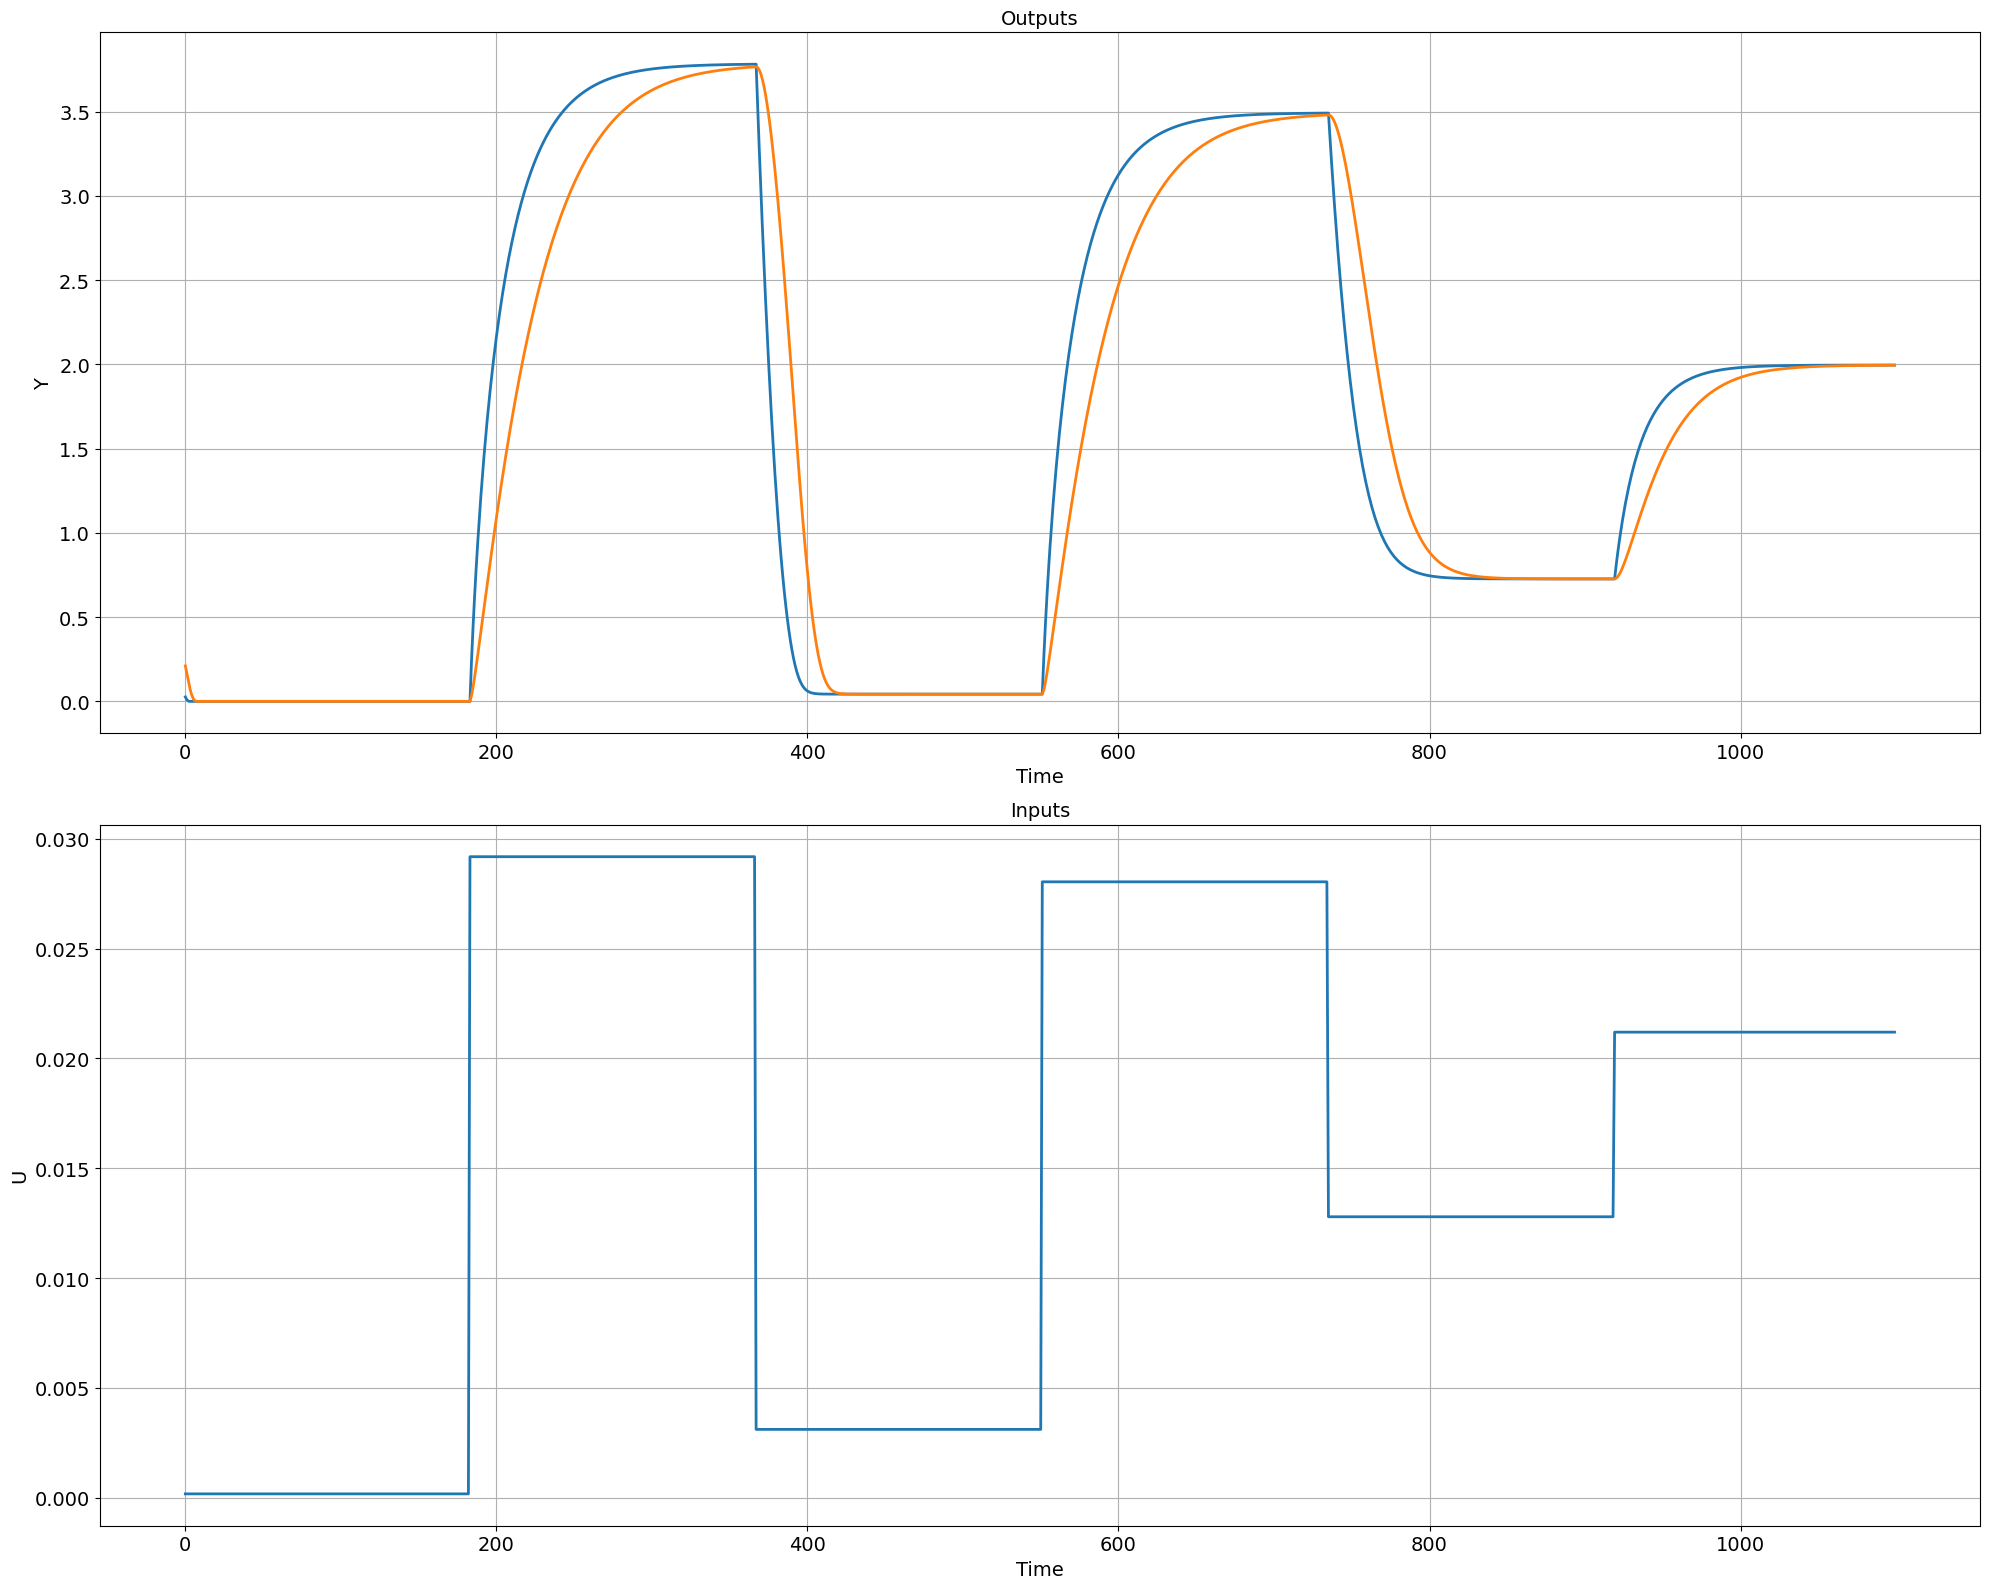

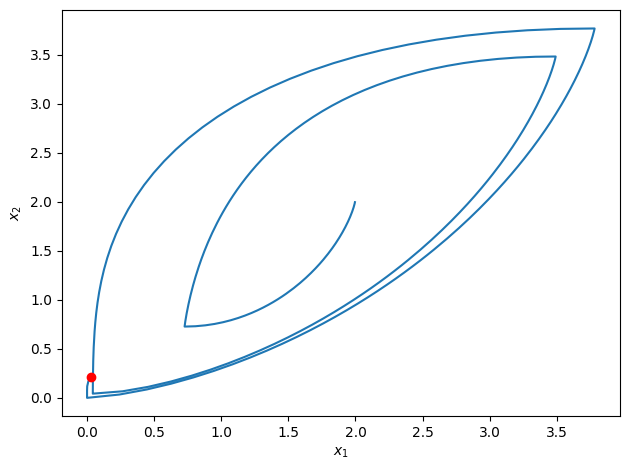

In [2]:
# %%  ground truth system
modelSystem = TwoTank()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1100, ts=ts)
plot.pltOL(Y=raw["Y"], U=raw["U"])
plot.pltPhase(X=raw["Y"])

In [3]:
def shift(data, delay):
    data["U"][:-delay] = data["U"][delay:]
    return


def add_noise(data, noise_level: float = 0.1, seed: int = 42):
    np.random.seed(seed)
    noise = np.random.normal(0, noise_level, data["X"].shape)
    data["X"] += noise
    data["X"][data["X"] < 0] = 0
    data["Y"] += noise
    data["Y"][data["Y"] < 0] = 0
    return


os.makedirs("data", exist_ok=True)
scipy.io.savemat("data/stats_of_system.mat", modelSystem.stats)

In [4]:
train_sim, dev_sim, test_sim = [
    modelSystem.simulate(nsim=20000, ts=ts) for i in range(3)
]
shift(train_sim, 20)
shift(dev_sim, 20)
shift(test_sim, 20)

with open("data/train_sim_clean.pkl", "wb") as fp:
    pickle.dump(train_sim, fp)

with open("data/val_sim_clean.pkl", "wb") as fp:
    pickle.dump(dev_sim, fp)

with open("data/test_sim_clean.pkl", "wb") as fp:
    pickle.dump(test_sim, fp)

# Get and save data - (Already done)

In [40]:
add_noise(train_sim, 0.1)
add_noise(dev_sim, 0.1)
add_noise(test_sim, 0.1)


with open("data/train_sim.pkl", "wb") as fp:
    pickle.dump(train_sim, fp)

with open("data/val_sim.pkl", "wb") as fp:
    pickle.dump(dev_sim, fp)

with open("data/test_sim.pkl", "wb") as fp:
    pickle.dump(test_sim, fp)

## Create training data of sampled trajectories


In [41]:
def np_to_moving_window(array, window_size):
    # Calculate the number of windows
    num_windows = array.shape[0] - window_size + 1

    # Use stride_tricks to create a view of the array with the moving window
    shape = (num_windows, window_size, 2)
    strides = (array.strides[0], array.strides[0], array.strides[1])
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

In [42]:
# function for converting np.array data to lstm input as moving window sequences
def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
    return np.array(X)

In [43]:
with open("data/train_sim.pkl", "rb") as fp:
    train_sim = pickle.load(fp)

with open("data/val_sim.pkl", "rb") as fp:
    val_sim = pickle.load(fp)

with open("data/test_sim.pkl", "rb") as fp:
    test_sim = pickle.load(fp)

In [44]:
def get_data(sys, nsim, nsteps, time, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """

    # train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    # shift(train_sim,20)
    # shift(dev_sim,20)
    # shift(test_sim,20)

    with open("data/train_sim.pkl", "rb") as fp:
        train_sim = pickle.load(fp)

    with open("data/val_sim.pkl", "rb") as fp:
        dev_sim = pickle.load(fp)

    with open("data/test_sim.pkl", "rb") as fp:
        test_sim = pickle.load(fp)

    nx = sys.nx
    nu = sys.nu
    nbatch = (nsim - time) // nsteps
    length = (nsim // nsteps) * nsteps
    print(length)
    mean_x = modelSystem.stats["Y"]["mean"]
    std_x = modelSystem.stats["Y"]["std"]
    mean_u = modelSystem.stats["U"]["mean"]
    std_u = modelSystem.stats["U"]["std"]

    def normalize(x, mean, std):
        return (x - mean) / std

    trainX_b = normalize(train_sim["Y"][:length], mean_x, std_x)
    trainX = trainX_b[time:].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU_b = normalize(train_sim["U"][:length], mean_u, std_u)
    trainU = trainU_b[time:].reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainUX_b = np.concatenate((trainX_b, trainU_b), axis=1)
    trainT = create_sequences(trainUX_b, time)
    trainT = trainT.reshape(nbatch, nsteps, time, nu + nx)
    trainT = torch.tensor(trainT, dtype=torch.float32)

    train_data = DictDataset(
        {
            "Y": trainX,
            "Y0": trainX[:, 0:1, :],
            "U": trainU,
            "timeYU0": trainT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
            "timeYU": trainT,
        },
        name="train",
    )
    train_loader = DataLoader(
        train_data,
        batch_size=bs,
        collate_fn=train_data.collate_fn,
        shuffle=True,
    )

    devX_b = normalize(dev_sim["Y"][:length], mean_x, std_x)
    devX = devX_b[time:].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU_b = normalize(dev_sim["U"][:length], mean_u, std_u)
    devU = devU_b[time:].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devUX_b = np.concatenate((devX_b, devU_b), axis=1)
    devT = create_sequences(devUX_b, time)
    devT = devT.reshape(nbatch, nsteps, time, nu + nx)
    devT = torch.tensor(devT, dtype=torch.float32)

    dev_data = DictDataset(
        {
            "Y": devX,
            "Y0": devX[:, 0:1, :],
            "U": devU,
            "timeYU0": devT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
            "timeYU": devT,
        },
        name="dev",
    )
    dev_loader = DataLoader(
        dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True
    )

    testX_b = normalize(test_sim["Y"][:length], mean_x, std_x)
    testX = testX_b[time:].reshape(nbatch, nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU_b = normalize(test_sim["U"][:length], mean_u, std_u)
    testU = testU_b[time:].reshape(nbatch, nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testUX_b = np.concatenate((testX_b, testU_b), axis=1)
    testT = create_sequences(testUX_b, time)
    testT = testT.reshape(nbatch, nsteps, time, nu + nx)
    testT = torch.tensor(testT, dtype=torch.float32)

    test_data = {
        "Y": testX,
        "Y0": testX[:, 0:1, :],
        "U": testU,
        "timeYU0": testT[:, 0:1, :, :].reshape(nbatch, time, nu + nx),
        "timeYU": testT,
    }

    return train_loader, dev_loader, test_data

In [45]:
nsim = 20000  # number of simulation steps in the dataset
nsteps = 80  # number of prediction horizon steps in the loss function
bs = 100  # minibatching batch size
time = 80  # number of lookback window as input to lstm
train_loader, dev_loader, test_data = get_data(
    modelSystem, nsim, nsteps, time, bs
)

20000


In [46]:
scipy.io.savemat("data/train_sim.mat", train_sim)
scipy.io.savemat("data/val_sim.mat", val_sim)
scipy.io.savemat("data/test_sim.mat", test_sim)

In [47]:
max_length = float("-inf")
min_length = float("inf")

for batch in train_loader:
    # Assuming each batch contains input tensors
    # You can modify this based on your data structure

    for key, tensor in batch.items():
        # Get the length of the tensor
        try:
            length = tensor.shape[
                0
            ]  # Assuming tensor is of shape (length, ...)

            # Update max_length and min_length
            max_length = max(max_length, length)
            min_length = min(min_length, length)
        except:
            pass

print("Longest tensor length:", max_length)
print("Shortest tensor length:", min_length)

Longest tensor length: 100
Shortest tensor length: 49


## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [48]:
# model parameters
nx_koopman = 40
n_hidden = 60
n_layers = 2
lstm_features = 8

**LSTM + Encoder and Decoder networks** 

In [49]:
f_yu = blocks.LSTMBlock(ny + nu, lstm_features)


def f_yuT(data):
    s = data.shape
    res = f_yu(data.reshape(s[0] * nsteps, time, ny + nu))
    return res.reshape(s[0], nsteps, lstm_features)


extract_time_features = Node(
    f_yuT, ["timeYU"], ["time_enc"], name="extract_time_features"
)

extract_time_features_0 = Node(
    f_yu, ["timeYU0"], ["time_enc0"], name="extract_time_features_0"
)

In [50]:
def stack(a, b):
    return torch.cat((a, b), dim=-1)

In [51]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny + lstm_features,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# initial condition encoder
encode_Y0 = Node(f_y, ["Y0_te"], ["x"], name="encoder_Y0")
# observed trajectory encoder
encode_Y = Node(f_y, ["Y_te"], ["x_latent"], name="encoder_Y")

stack_Y0 = Node(stack, ["Y0", "time_enc0"], ["Y0_te"], name="stack_Y0")
stack_Y = Node(stack, ["Y", "time_enc"], ["Y_te"], name="stack_Y")

In [52]:
# matrice B
K_B = torch.nn.Linear(nu, nx_koopman, bias=False)
encode_U = Node(K_B, ["U"], ["u_real"], name="encoder_U")

In [53]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(
    nx_koopman,
    ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ELU,
    hsizes=n_layers * [n_hidden],
)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ["x"], ["yhat"], name="decoder_y")

In [54]:
# instantiate Koopman operator matrix
stable = True  # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(
        nx_koopman, nx_koopman, sigma_min=0.01, sigma_max=1.0, bias=False
    )
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.0 * (K_reg_error == 0.0)
    K_reg_loss.name = "SVD_loss"
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [55]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K (x_k + u_k)
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [56]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ["x", "u_real"], ["x"], name="K")

# latent Koopmann rollout
dynamics_model = System([Koopman], name="Koopman", nsteps=nsteps)

In [57]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [
    extract_time_features,
    extract_time_features_0,
    stack_Y0,
    stack_Y,
    encode_Y0,
    encode_Y,
    encode_U,
    dynamics_model,
    decode_y,
]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [58]:
# variables
Y = variable("Y")  # observed
yhat = variable("yhat")  # predicted output
x_latent = variable(
    "x_latent"
)  # encoded output trajectory in the latent space
# u_latent = variable('u_latent')  # encoded input trajectory in the latent space
u_real = variable("u_real")  # real input trajectory
x = variable("x")  # Koopman latent space trajectory

# xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10.0 * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.0 * (yhat[:, 1, :] == Y[:, 1, :]) ^ 2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1.0 * (x[:, 1:-1, :] == x_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [59]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [60]:
print(problem.input_keys)
print(problem.output_keys)

['Y_te', 'timeYU0', 'time_enc', 'u_real', 'timeYU', 'Y0', 'Y', 'x', 'time_enc0', 'U', 'x_latent', 'yhat', 'Y0_te']
['C_ineq_values', 'Y_te', 'time_enc', 'u_real', 'penalty_loss', 'C_eq_values', 'C_ineq_violations', 'loss', 'x', 'objective_loss', 'C_eq_violations', 'time_enc0', 'x_latent', 'yhat', 'C_violations', 'Y0_te', 'C_values']


## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [61]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=1500,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [62]:
# %% train
start = tim.time()
best_model = trainer.train()
problem.load_state_dict(best_model)
end = tim.time()

epoch: 0  train_loss: 23.63658332824707
epoch: 1  train_loss: 17.498369216918945
epoch: 2  train_loss: 11.840962409973145
epoch: 3  train_loss: 8.43363094329834
epoch: 4  train_loss: 7.514451503753662
epoch: 5  train_loss: 8.3814058303833
epoch: 6  train_loss: 8.306042671203613
epoch: 7  train_loss: 7.206451416015625
epoch: 8  train_loss: 7.094306468963623
epoch: 9  train_loss: 7.112346649169922
epoch: 10  train_loss: 6.860936641693115
epoch: 11  train_loss: 6.910557270050049
epoch: 12  train_loss: 6.881269454956055
epoch: 13  train_loss: 6.190304279327393
epoch: 14  train_loss: 6.63842248916626
epoch: 15  train_loss: 6.017845153808594
epoch: 16  train_loss: 6.531824588775635
epoch: 17  train_loss: 6.333542346954346
Interrupted training loop.


In [87]:
# elapsed time
print("Elapsed time training: ", end - start)

Elapsed time training:  961.3248376846313


In [89]:
torch.save(best_model, "../results/LSTM_" + str(lstm_features) + ".pth")

## System Identification results

In [30]:
# update the rollout length based on the test data
problem.nodes[7].nsteps = 2400

In [31]:
res = problem.nodes[1]({"timeYU0": test_data["timeYU0"][0:1, :, :]})
res1 = problem.nodes[2]({
    "time_enc0": res["time_enc0"],
    "Y0": test_data["Y0"][0:1, :, :],
})
res2 = problem.nodes[4](res1)
resU = problem.nodes[6]({"U": test_data["U"][:30, :, :].reshape(1, 2400, 1)})
res3 = problem.nodes[7]({"x": res2["x"], "u_real": resU["u_real"]})
res4 = problem.nodes[8](res3)

In [32]:
pred_traj = res4["yhat"][:, :-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data["Y"][:30, :, :].detach().numpy().reshape(-1, nx).T
input_traj = (
    test_data["U"][:30, :, :]
    .reshape(1, 2400, 1)
    .detach()
    .numpy()
    .reshape(-1, nu)
    .T
)

In [33]:
mean_x = modelSystem.stats["Y"]["mean"]
std_x = modelSystem.stats["Y"]["std"]
mean_u = modelSystem.stats["U"]["mean"]
std_u = modelSystem.stats["U"]["std"]


def normalize(x, mean, std):
    return (x - mean) / std


def denormalize(x, mean, std):
    return x * std + mean


pred = {
    "h1": denormalize(pred_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(pred_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("../results/pred_sim_DeReK.mat", pred)
true = {
    "h1": denormalize(true_traj.T, mean_x, std_x)[:, 0],
    "h2": denormalize(true_traj.T, mean_x, std_x)[:, 1],
}
scipy.io.savemat("data/true_sim.mat", true)

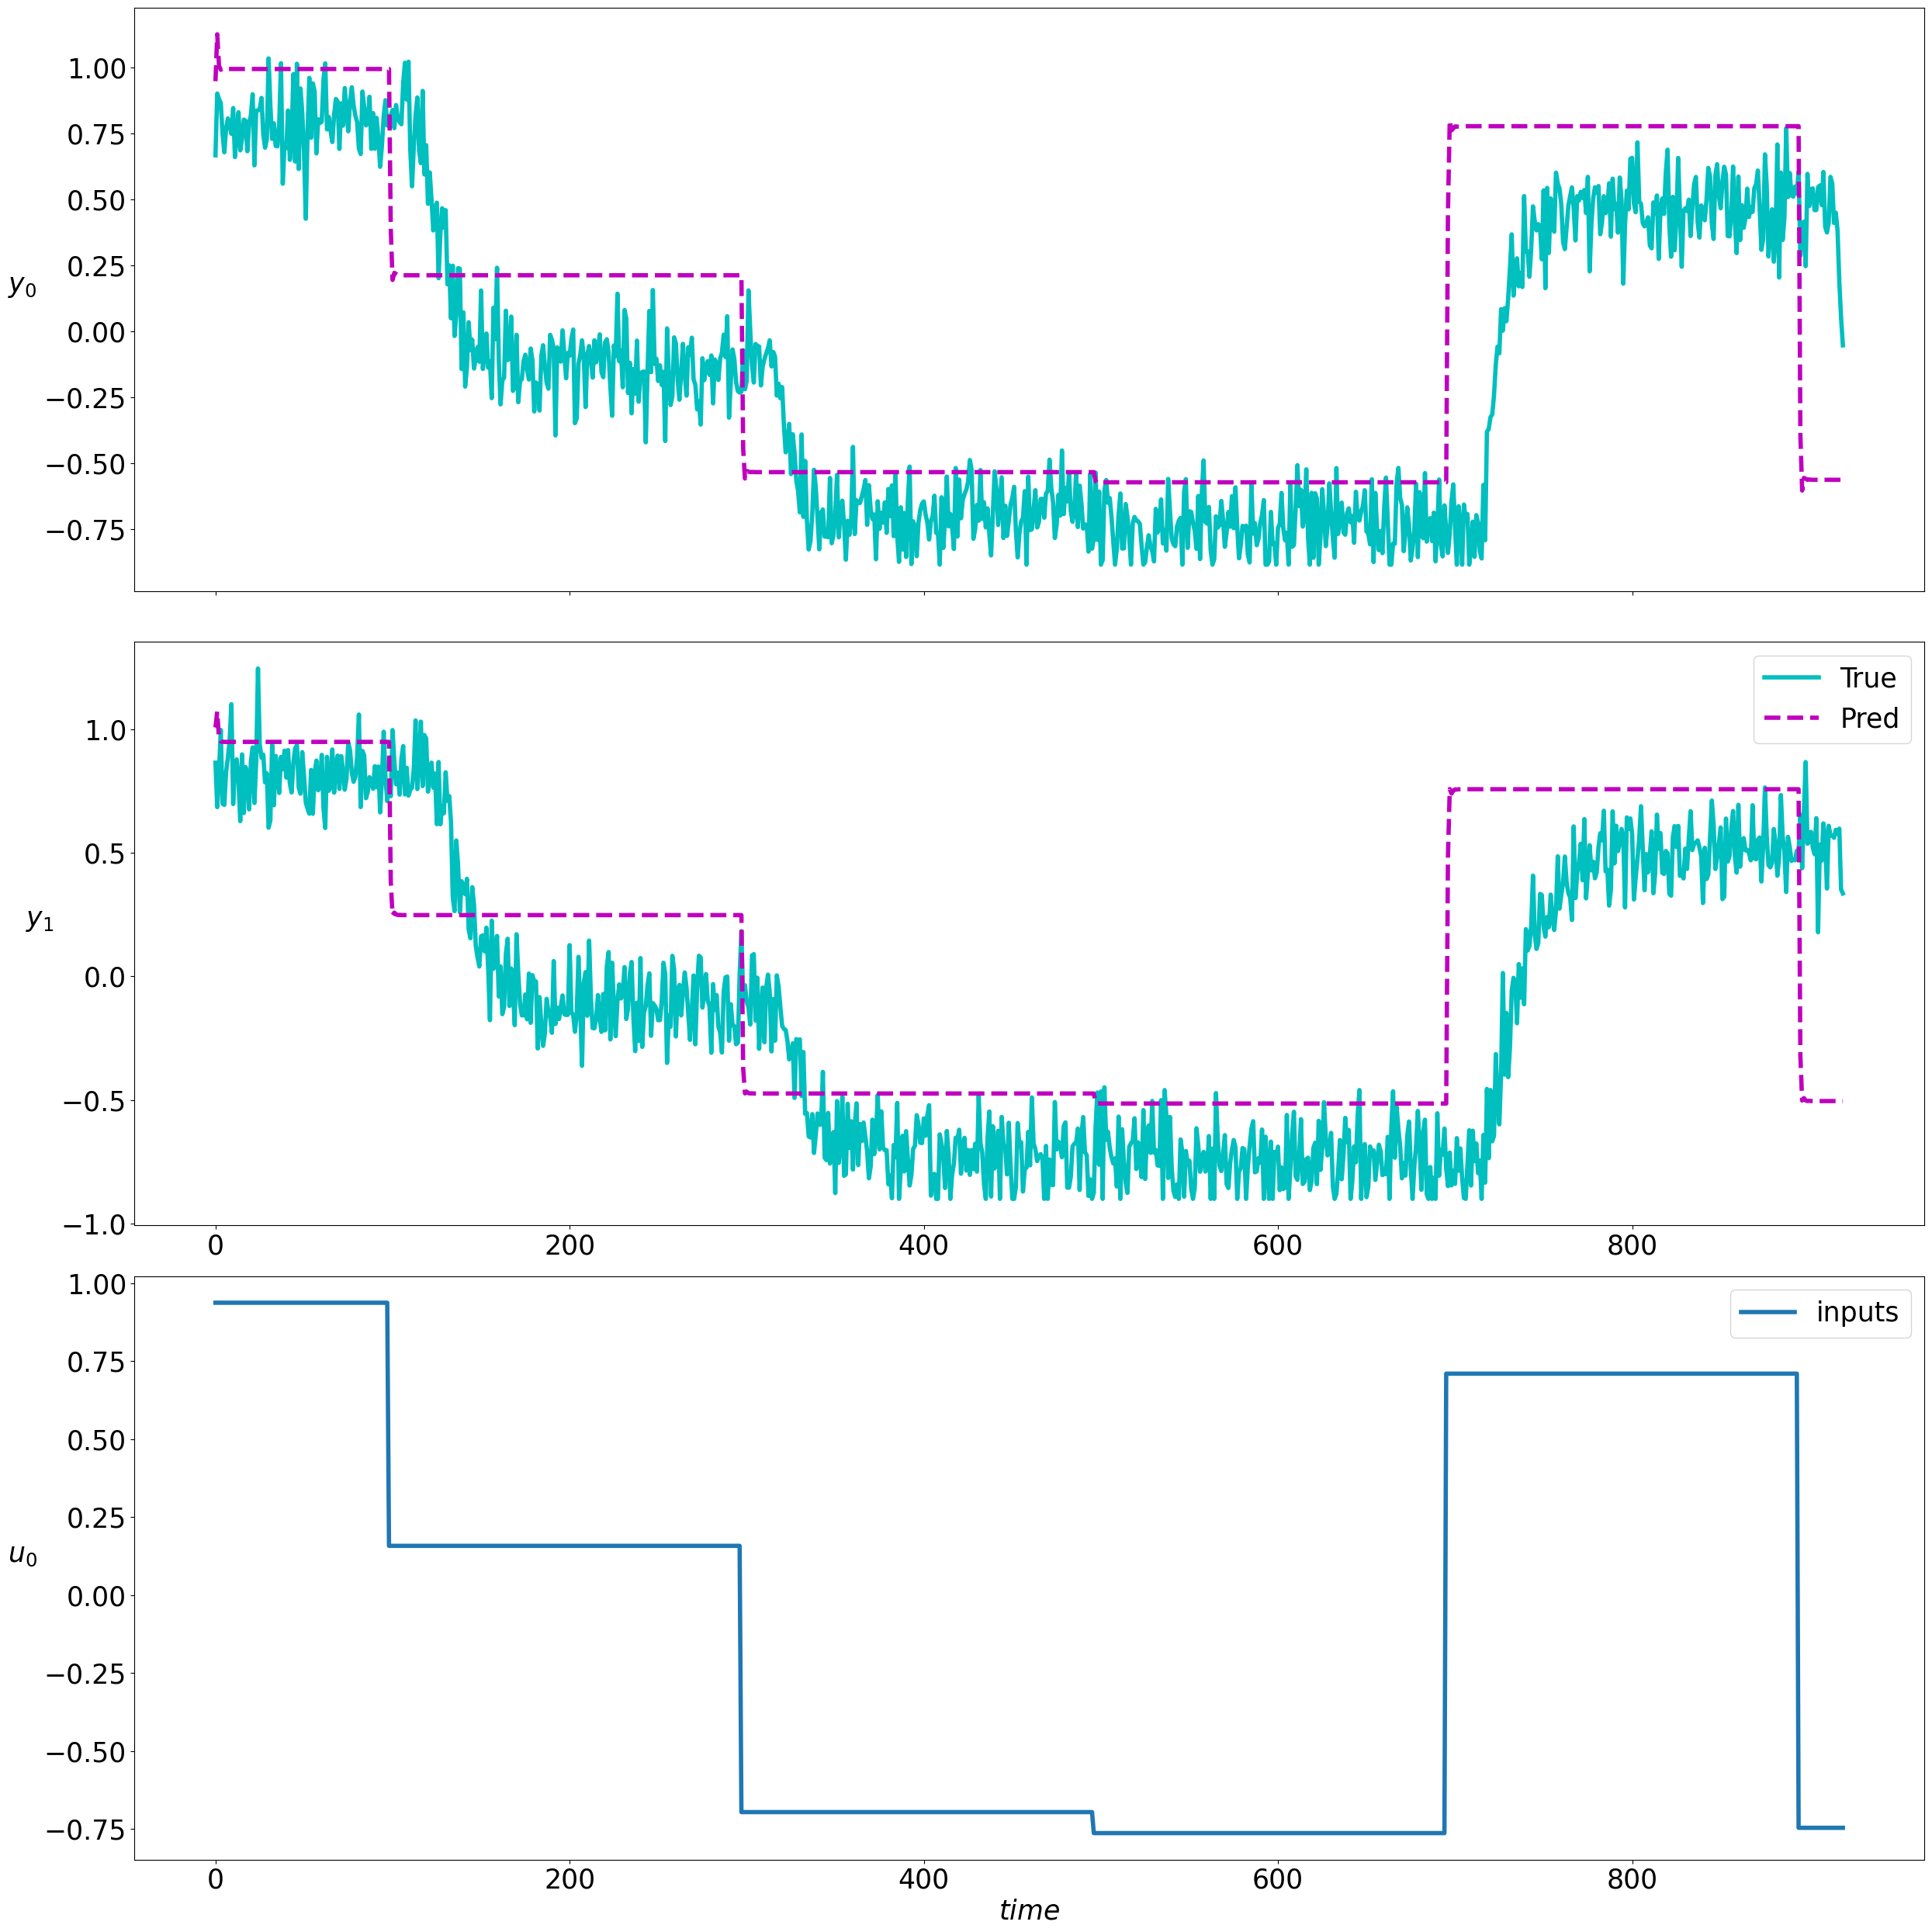

In [ ]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))
part = 920


x_labels = [f"$y_{k}$" for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:part], "c", linewidth=4.0, label="True")
    axe.plot(t2[:part], "m--", linewidth=4.0, label="Pred")
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f"$u_{k}$" for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row + nx]
    axe.plot(u[:part], linewidth=4.0, label="inputs")
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel("$time$", fontsize=figsize)
plt.tight_layout()

In [101]:
# save A and B matrices, where A = K.effective_W() and B = K_B.weight
A = K.effective_W().detach().numpy()
B = K_B.weight.detach().numpy()

np.save("../results/A_DeReK_noise.npy", A)
np.save("../results/B_DeReK_noise.npy", B)

In [35]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

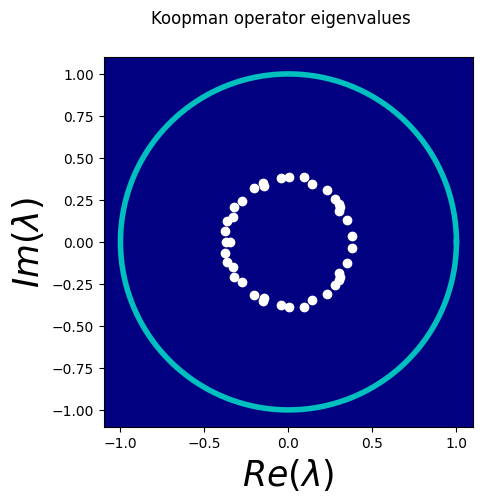

In [ ]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, "c", linewidth=4)
ax1.plot(eReal, eImag, "wo")
ax1.set_aspect("equal", "box")
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle("Koopman operator eigenvalues")